# Crossmap Notebook

## Setup

### Install dependencies

In [ ]:
# Uncomment the lines below if you have access to an IONQ backend (specified in .env)

# import os
# from dotenv import load_dotenv
# load_dotenv()
# from qiskit_ionq import IonQProvider
# provider = IonQProvider(os.getenv('IONQ_PROVIDER_TOKEN'))
# backend = provider.get_backend("ionq_simulator")  # use this one to access a simulator of a quantum computer
# backend = provider.get_backend("ionq_qpu.aria-1") # use this one to access the actual quantum hardware called "aria-1"

In [ ]:
!pip install qiskit
!pip install qiskit_optimization
!pip install qiskit_aer
!pip install qiskit_ionq

In [ ]:
from qiskit import *
from qiskit.visualization import *
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [ ]:
import numpy as np
from qiskit_optimization.algorithms import ADMMOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_aer import Aer
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import ADMMOptimizer, MinimumEigenOptimizer, ADMMParameters
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
qp = QuadraticProgram()

In [ ]:
!pip install ortools
from ortools.linear_solver import pywraplp
import time  # for timing comparisons

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

### Utility functions

#### Matrix Operations

In [ ]:
# Create a 2D matrix filled with 0s and place nodes with optional radius metric
# Returns a 'rows' by 'cols' 2D Array 
def create_matrix(rows, cols, node_placements=None, radius=None):
    # Initialize the matrix with 0s
    matrix = [[0 for _ in range(cols)] for _ in range(rows)]
    
    # If no node placements provided, return empty matrix
    if node_placements is None:
        return matrix

    # Helper function to check if coordinates are within matrix bounds
    def is_within_bounds(x, y):
        return 0 <= x < rows and 0 <= y < cols

    # Place nodes in the matrix
    for x0, y0 in node_placements:
        if is_within_bounds(x0, y0):
            # If radius is specified, limit the distance expansion
            limit_radius = radius if radius is not None else max(rows, cols)
            # Determine the bounding box
            x_min = max(0, x0 - limit_radius)
            x_max = min(rows - 1, x0 + limit_radius)
            y_min = max(0, y0 - limit_radius)
            y_max = min(cols - 1, y0 + limit_radius)
            # Iterate over the bounding box
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    if matrix[x][y] == 0:
                        # Compute Euclidean distance
                        dist = ((x - x0)**2 + (y - y0)**2)**0.5
                        # Calculate the value to be assigned
                        value = max(0, int(round(limit_radius - dist)))
                        if value > 0:
                            matrix[x][y] = value
    return matrix

In [ ]:
# Convert the matrix to a string with dynamic spacing, adjusting based on the symbol length
def matrix_to_string(matrix, none_entry_symbol='0'):
    # If the none_entry_symbol is more than 1 character (like '42'), we use wider spacing
    if len(str(none_entry_symbol)) > 1:
        max_width = max(len(str(cell)) for row in matrix for cell in row)
        cell_width = max(max_width, len(str(none_entry_symbol)))
    else:
        # For shorter symbols (like '-'), just use a single space
        cell_width = 1

    # Building the string representation of the matrix with appropriate spacing
    result = ""
    for row in matrix:
        row_str = ' '.join([f'{str(cell):>{cell_width}}' if cell != 0 else f'{none_entry_symbol:>{cell_width}}' for cell in row])
        result += row_str + "\n"
    
    return result

# Example usage
matrix = create_matrix(10, 10, [(3, 3)], 4)
matrix_str = matrix_to_string(matrix, '-')
print(matrix_str)

#### Dimension Transformations

In [ ]:
# Creates a list where every element is a 
# flattend version of a 2D matrix (with rows*cols dimensions).
# 
# Each list element represents one possible output of
# where the new optimized node placement could be. 

# This will be used to feed as the distance (D) input for the algorithm
def flatten_2D_to_1D(rows: int, cols: int, node_placements: list = [], radius: int = 2) -> list:
  D = []
  j = []
  count = 0
  for x in range(rows):
    for y in range(cols):
      count+=1
      matrix = create_matrix(rows, cols, node_placements + [(x, y)], radius)
      
      # Replace entry (i,j) with a 1, to represent one possibility
      for i in matrix:
        j = j + i
      D.append(j)
      j = []

  return D

# Example 1:
D = flatten_2D_to_1D(1, 3, [], 1)
print(D)

# Example 2:
D = flatten_2D_to_1D(1, 3, [], 2)
print(D)

In [ ]:
# Unflatten a 1D array back into a 2D matrix representation 
# This will later be used for printing the results of the algorithm
def unflatten_1D_to_2D_matrix(D: list, rows: int, cols: int, radius = 2):
    unflattened = []
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(D[i * cols + j])
        unflattened.append(row)
    
    # Create the matrix using the unflattened data
    node_placements = [(i, j) for i in range(rows) for j in range(cols) if unflattened[i][j] != 0]
    matrix = create_matrix(rows, cols, node_placements, radius)
    
    return matrix

# Example 1:
x_star = [0, 0, 0, 0, 1, 0, 0, 0, 0]
result = unflatten_1D_to_2D_matrix(x_star, 3, 3)
print(result)

# # Example 2:
x_star = [0, 1, 0]
result = unflatten_1D_to_2D_matrix(x_star, 1, 3)
print(result)

In [ ]:
def plot_colored_matrix_with_grid(matrix, ax=None, none_entry_color='white', cmap='Blues', show_colorbar=True):
    try:
        matrix_np = np.array(matrix)
        matrix_with_nan = np.where(matrix_np == 0, np.nan, matrix_np)

        # Create colormap
        cmap = plt.get_cmap(cmap)
        cmap.set_bad(color=none_entry_color)

        # Handle normalization
        if np.all(np.isnan(matrix_with_nan)):
            norm = mcolors.Normalize(vmin=0, vmax=1)
        else:
            norm = mcolors.Normalize(vmin=0, vmax=np.nanmax(matrix_with_nan))

        # Create figure if needed
        fig = None
        if ax is None:
            fig_width = max(8, matrix_np.shape[1] // 10)
            fig_height = max(8, matrix_np.shape[0] // 10)
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

        # Plot matrix and store the return value
        img = ax.imshow(matrix_with_nan, cmap=cmap, norm=norm, interpolation='nearest')

        # Grid lines
        ax.set_xticks(np.arange(-0.5, matrix_np.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, matrix_np.shape[0], 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        ax.tick_params(which='minor', size=0)

        # Ticks and labels
        if matrix_np.shape[1] > 50 or matrix_np.shape[0] > 50:
            xtick_step = max(1, matrix_np.shape[1] // 10)
            ytick_step = max(1, matrix_np.shape[0] // 10)
            ax.set_xticks(np.arange(0, matrix_np.shape[1], xtick_step))
            ax.set_yticks(np.arange(0, matrix_np.shape[0], ytick_step))
            ax.set_xticklabels(np.arange(0, matrix_np.shape[1], xtick_step))
            ax.set_yticklabels(np.arange(0, matrix_np.shape[0], ytick_step))
        else:
            ax.set_xticks(np.arange(matrix_np.shape[1]))
            ax.set_yticks(np.arange(matrix_np.shape[0]))
            ax.set_xticklabels(np.arange(matrix_np.shape[1]))
            ax.set_yticklabels(np.arange(matrix_np.shape[0]))

        # Add colorbar only if requested
        if show_colorbar:
            plt.colorbar(img, ax=ax)

        return img

    except Exception as e:
        print(f"Error in plot_colored_matrix_with_grid: {str(e)}")
        return None

In [ ]:
def calculate_solution_stats(matrix, time=None):
    """Calculate and format statistics for a solution matrix"""
    # Count nodes (non-zero values)
    nodes_placed = len([x for row in matrix for x in row if x > 1])
    
    # Calculate coverage
    total_cells = len(matrix) * len(matrix[0])
    covered_cells = len([x for row in matrix for x in row if x >= 1])
    coverage = covered_cells / total_cells * 100
    
    # Format stats vertically
    if time is not None:
        stats_text = f'Time: {time:.2f}s\nNodes: {nodes_placed}\nCoverage: {coverage:.1f}%'
    else:
        stats_text = f'Nodes: {nodes_placed}\nCoverage: {coverage:.1f}%'
        
    return {
        'nodes': nodes_placed,
        'coverage': coverage,
        'formatted_text': stats_text
    }

In [ ]:
def plot_solutions_comparison(quantum_solution, classical_solution, quantum_time, classical_time, rows, cols, radius):
    """Plot input and solutions side by side with statistics"""
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[0.5, 2, 0.5], hspace=0.4)
    
    # Main title - larger, bolder
    fig.suptitle(f'Grid Configuration: {rows}x{cols} with radius {radius}', 
                 fontsize=20, y=0.98, weight='bold')
    
    # Top row - input visualization
    ax_input = fig.add_subplot(gs[0, :])
    empty_matrix = [[0 for _ in range(cols)] for _ in range(rows)]
    plot_colored_matrix_with_grid(empty_matrix, ax=ax_input, show_colorbar=False)
    ax_input.set_title('Input Grid', fontsize=16, weight='bold', pad=20)
    
    # Middle row - solutions with larger titles
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    
    # Calculate stats
    q_stats = calculate_solution_stats(quantum_solution, quantum_time)
    c_stats = calculate_solution_stats(classical_solution, classical_time)
    
    # Plot solutions
    plot_colored_matrix_with_grid(quantum_solution, ax=ax1, show_colorbar=False)
    im = plot_colored_matrix_with_grid(classical_solution, ax=ax2, show_colorbar=False)
    
    # Set solution title
    ax1.set_title("Quantum Solution", fontsize=16, weight='bold', pad=10)
    ax2.set_title("Classical Solution", fontsize=16, weight='bold', pad=10)
    
    # Bottom row - stats text
    ax_stats1 = fig.add_subplot(gs[2, 0])
    ax_stats2 = fig.add_subplot(gs[2, 1])
    
    # Stats formattin
    stats_style = dict(
        ha='center', 
        va='center', 
        fontsize=35,  # Increased from 14 to 16
    )
    
    # Add stats text
    ax_stats1.text(0.5, 0.5, q_stats['formatted_text'], **stats_style)
    ax_stats2.text(0.5, 0.5, c_stats['formatted_text'], **stats_style)
    
    # Hide stats axes
    ax_stats1.axis('off')
    ax_stats2.axis('off')
    
    # Add single colorbar at bottom
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    plt.show()

### Algorithm Implementation

#### Solve using Classical Optimization

In [ ]:
def run_classical_optimization(rows: int, cols: int, radius: int = 2):
    """Classical optimization using Google OR-Tools."""
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    # Variables
    x = {}
    for i in range(rows):
        for j in range(cols):
            x[i,j] = solver.IntVar(0, 1, f'x_{i}_{j}')
            
    # Coverage constraints
    for i in range(rows):
        for j in range(cols):
            coverage = []
            for ni in range(max(0, i-radius), min(rows, i+radius+1)):
                for nj in range(max(0, j-radius), min(cols, j+radius+1)):
                    if ((ni-i)**2 + (nj-j)**2)**0.5 <= radius:
                        coverage.append(x[ni,nj])
            solver.Add(sum(coverage) >= 1)
    
    solver.Minimize(sum(x.values()))
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        # Get node placements from solution
        node_placements = []
        for i in range(rows):
            for j in range(cols):
                if int(x[i,j].solution_value()) == 1:
                    node_placements.append((i,j))
        
        # Create matrix with radius reflection using create_matrix()
        solution = create_matrix(rows, cols, node_placements, radius)
        return solution, solver.Objective().Value()
    
    return None, None

#### Solve using Quantum Optimization:
This is the implemented QUBO algorithm to focus on.

In [ ]:
def run_quantum_optimization(rows: int, cols: int, radius: int = 2, debug_circuit: bool = False, debug_iterations: bool = False):
    # Step 1: Generate and prepare initial data
    D = flatten_2D_to_1D(rows, cols, [], radius)
    D = np.asarray(D)
    rho = 1.1
    mu0 = 1
    k = 0

    # Step 2: Initialize optimization parameters
    z_star = np.zeros_like(D)
    lambda_star = np.zeros_like(D)
    mu_star = mu0

    # Step 3: Define helper functions
    def L(x, z, lambda_, mu):
        term1 = np.transpose(np.ones(len(D))) * x
        term2 = np.transpose(lambda_)*D*x
        term3 = (mu/2)*(np.transpose(x)*np.transpose(D)*D*x - np.transpose(np.ones(len(D)) + z)*D*x)
        return term1 + term2 + term3

    def c(x,z):
        x_reshaped = x.reshape((-1, 1))
        return np.dot(D, x_reshaped) - np.ones_like(z) - z

    # Step 4: Set up quantum instance
    rho_initial = 1.1
    factor_c = 10.0
    beta = 100.0
    maxiter = 100
    admm_params = ADMMParameters(rho_initial=rho_initial, factor_c=factor_c, beta=beta, maxiter=maxiter)
    sampler = Sampler()
    qubo_optimizer = MinimumEigenOptimizer(QAOA(sampler=sampler, optimizer=COBYLA()))
    admm_optimizer = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer)

    # Step 5: Optimization loop
    converged = False
    while not converged:
        k += 1
        qp = QuadraticProgram()
        
        for i in range(len(D)):
            qp.binary_var(name=f'x_{i}')

        linear_terms = {}
        for i in range(len(D)):
            linear_terms[f'x_{i}'] = 1 + np.dot(lambda_star[i, :], D[:, i]) - 0.5 * mu_star * np.dot((1 + z_star[i, :]), D[:, i])

        quadratic_terms = {}
        for i in range(len(D)):
            for j in range(i, len(D)):
                quadratic_terms[(f'x_{i}', f'x_{j}')] = 0.5 * mu_star * np.dot(D[:, i], D[:, j])

        qp.minimize(linear=linear_terms, quadratic=quadratic_terms)

        # Step 6: Solve and print iteration results
        result = admm_optimizer.solve(qp)
        if (k == 1 and debug_circuit):
            # print(circuit)
            circuit = qubo_optimizer.min_eigen_solver.ansatz
            # Save circuit image directly
            circuit.draw(output='mpl', 
                        filename='quantum_circuit.png',
                        style={'backgroundcolor': '#FFFFFF'})
            
            # Display saved image in notebook
            from IPython.display import Image
            display(Image('quantum_circuit.png'))
            
        x_star = result.x[:9] if len(D) == 9 else result.x[:rows*cols]
        if debug_iterations:
            print(f"Iteration {k} x_star:", x_star)

        # Step 7: Update z
        z_temp = z_star
        z_star = np.maximum(np.zeros_like(D), c(x_star, z_star)+z_star)

        # Step 8: Update lambda
        lambda_star = lambda_star + mu_star * c(x_star, z_star)

        # Step 9: Update mu
        if np.linalg.norm(c(x_star, z_star)) > 10 * mu_star * np.linalg.norm(D * -1*(z_temp - z_star)):
            mu_star = rho*mu_star
        elif 10 * mu_star * np.linalg.norm(c(x_star, z_star)) < np.linalg.norm(D * -1*(z_temp - z_star)):
            mu_star = mu_star/rho

        if k == 5:
            converged = True

    # Convert and return result
    final_matrix = unflatten_1D_to_2D_matrix(x_star, rows, cols, radius)
    return final_matrix

#### Visualization

## Results

### Comparison Tests
Testing different grid configurations and comparing quantum vs classical solutions.


Testing 1x3 grid with radius 2


C:\Users\the10\AppData\Local\Temp\ipykernel_49816\2445112642.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\the10\AppData\Local\Temp\ipykernel_49816\330242125.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


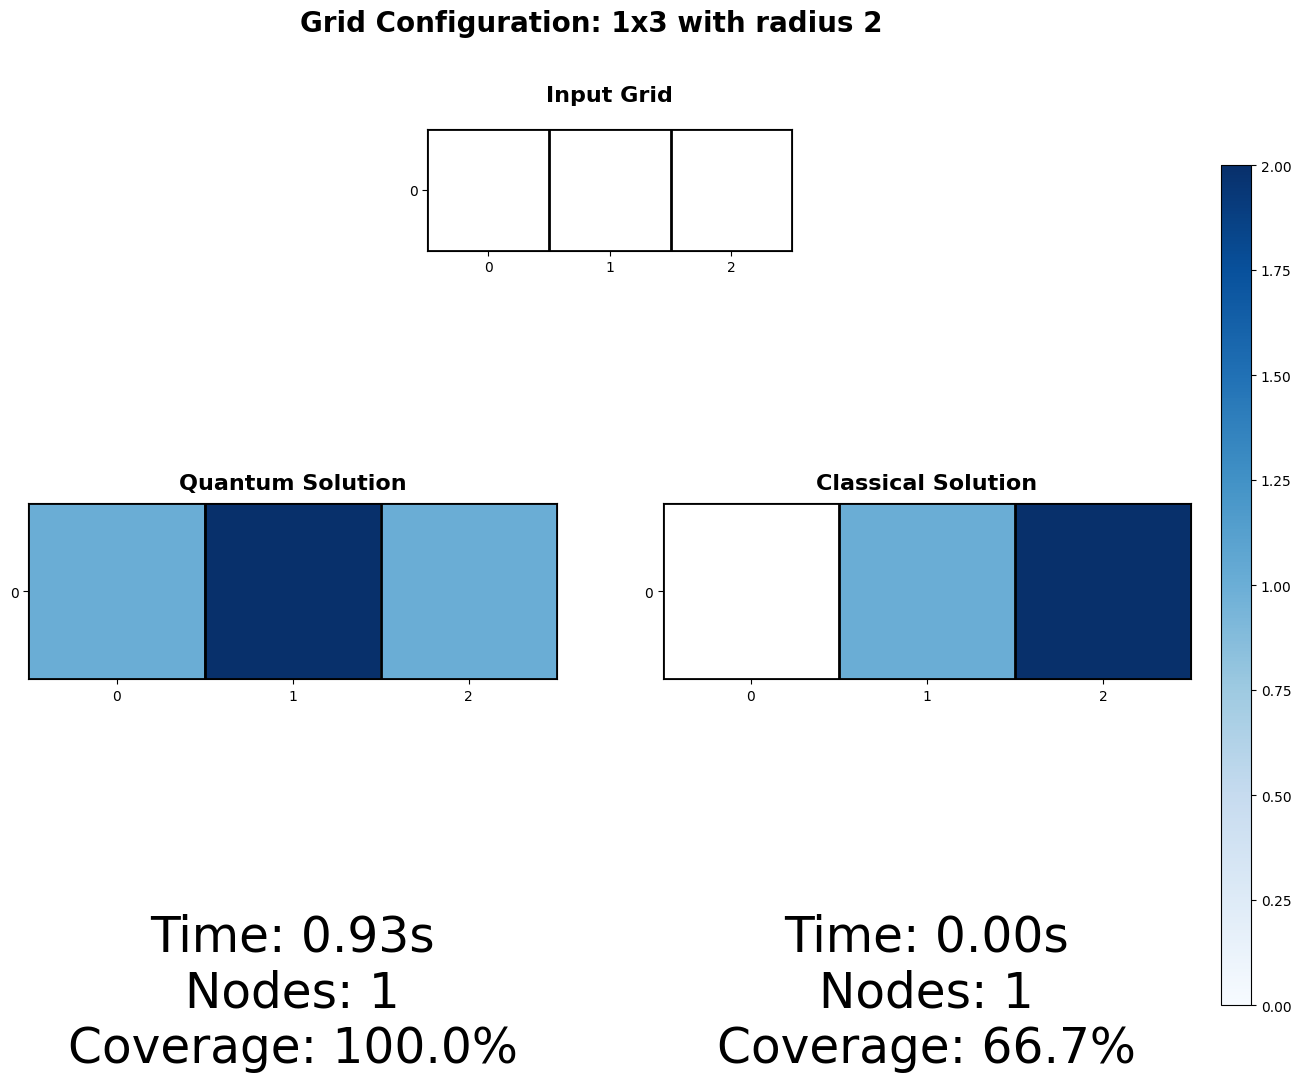

In [55]:
# Test configurations (comment/uncomment any of the below, or make your own)
test_configs = [
    (1, 3, 2),  # Small linear grid
    # (1, 5, 2),  # Medium linear grid 
    # (2, 3, 2),  # Small rectangular grid
    # (2, 5, 2)  # Medium rectangular grid
    # (2, 2, 2),   # Small square grid
    # (3, 3, 2)   # Medium square grid
]

# Run comparison tests
for rows, cols, radius in test_configs:
    print(f"\nTesting {rows}x{cols} grid with radius {radius}")
    
    # Time classical solution
    t0 = time.time()
    classical_solution, objective = run_classical_optimization(rows, cols, radius)
    classical_time = time.time() - t0
    
    # Time quantum solution
    t0 = time.time()
    quantum_solution = run_quantum_optimization(rows, cols, radius)
    quantum_time = time.time() - t0
    
    # Plot comparison with stats and dimensions
    plot_solutions_comparison(
        quantum_solution,
        classical_solution, 
        quantum_time,
        classical_time,
        rows,
        cols, 
        radius
    )